In [49]:
%%capture
%pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [50]:
# Update FILE_PATHS in 'imports.py' with the paths to the PUMS files before using this.
from imports import FILE_PATHS
files = FILE_PATHS
def get_dataframe():
    df = spark.read.csv(files,header=True,inferSchema=True)
    return df

### Variables Used
- Annual Wages (past 12 months) (WAGP)
- White, or other combination (used for 'Minority Status') (RACWHT)

In [51]:
mean_wage = get_dataframe()

In [52]:
from pyspark.sql.functions import avg
from pyspark.sql.functions import percentile_approx

In [53]:
df = get_dataframe()
mean_wage = (df
    .groupBy(df['ST'],df['RACWHT'])
    .agg(
        avg('WAGP').alias('avg_salary'),
        percentile_approx("WAGP", 0.5,accuracy=10000).alias('median')
    )
    .toPandas())

In [75]:
# STATE_MAPS makes this more readable
from imports import STATE_MAPS
mean_wage['ST'] = mean_wage['ST'].replace(STATE_MAPS)
mean_wage['avg_salary'] = mean_wage['avg_salary'].round(0)

def div_list(list):
    return round(list[1]/list[0]*100,2)
# Adding percent that minority's income is of non-minority
mean_wage['discrepency'] = mean_wage['ST'].apply(
    lambda x: div_list(mean_wage.loc[mean_wage['ST'] == x]['avg_salary'].tolist()))
mean_wage = (mean_wage
    .sort_values(by=['ST','discrepency','avg_salary'],ascending=False)
    .reset_index(drop=True))

In [76]:
mean_wage.head(10)

,ST,RACWHT,avg_salary,median,discrepency
0,Wyoming,1,23723.0,12000,74.87
1,Wyoming,0,17761.0,9600,74.87
2,Wisconsin,1,23227.0,12000,74.17
3,Wisconsin,0,17227.0,5900,74.17
4,West Virginia,1,16505.0,1700,95.52
5,West Virginia,0,15766.0,2500,95.52
6,Washington,1,26668.0,10400,87.92
7,Washington,0,23446.0,12000,87.92
8,Virginia,1,31894.0,15000,74.52
9,Virginia,0,23767.0,13000,74.52


In [10]:
import seaborn as sns, matplotlib.pyplot as plt

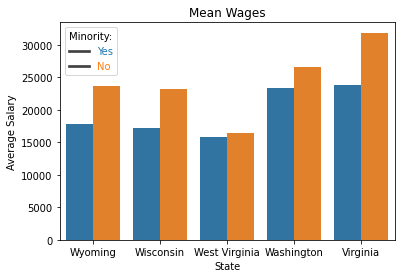

In [48]:
mean_plt = sns.barplot(x='ST',y='avg_salary',data=mean_wage.head(10), hue='RACWHT').set(title='Mean Wages')
plt.ylabel('Average Salary')
plt.xlabel('State')
plt.legend(labelcolor=['tab:blue','tab:orange'],title='Minority:',labels=['Yes','No'])
plt.show()

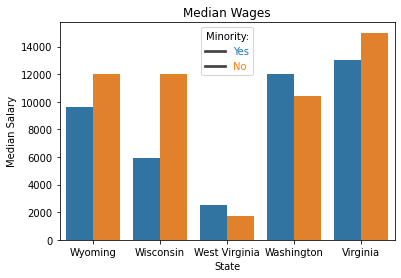

In [47]:
median_plt = sns.barplot(x='ST',y='median',data=mean_wage.head(10), hue='RACWHT').set(title='Median Wages')
plt.ylabel('Median Salary')
plt.xlabel('State')
plt.legend(labelcolor=['tab:blue','tab:orange'],title='Minority:',labels=['Yes','No'],)
plt.show()